# MMR

## Dataset creation

### Function to create a random dynamic circuit

This is a modified version of the Qiskit function random_circuit()

In [11]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2017.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""Utility functions for generating random circuits."""

import numpy as np

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Reset
from qiskit.circuit.library.standard_gates import (
    IGate,
    U1Gate,
    U2Gate,
    U3Gate,
    XGate,
    YGate,
    ZGate,
    HGate,
    SGate,
    SdgGate,
    TGate,
    TdgGate,
    RXGate,
    RYGate,
    RZGate,
    CXGate,
    CYGate,
    CZGate,
    CHGate,
    CRZGate,
    CU1Gate,
    CU3Gate,
    SwapGate,
    RZZGate,
    CCXGate,
    CSwapGate,
)
from qiskit.circuit.exceptions import CircuitError


def my_random_circuit(
    num_qubits, depth, max_operands=3, measure=False, conditional=True, reset=False, seed=None, measurements_density=1
):
    """Generate random circuit of arbitrary size and form.

    This function will generate a random circuit by randomly selecting gates
    from the set of standard gates in :mod:`qiskit.extensions`. For example:

    .. jupyter-execute::

        from qiskit.circuit.random import random_circuit

        circ = random_circuit(2, 2, measure=True)
        circ.draw(output='mpl')

    Args:
        num_qubits (int): number of quantum wires
        depth (int): layers of operations (i.e. critical path length)
        max_operands (int): maximum operands of each gate (between 1 and 3)
        measure (bool): if True, measure all qubits at the end
        conditional (bool): if True, insert middle measurements and conditionals
        reset (bool): if True, insert middle resets
        seed (int): sets random seed (optional)

    Returns:
        QuantumCircuit: constructed circuit

    Raises:
        CircuitError: when invalid options given
    """
    if max_operands < 1 or max_operands > 3:
        raise CircuitError("max_operands must be between 1 and 3")

    one_q_ops = [
        #IGate,
        U1Gate,
        U2Gate,
        U3Gate,
        XGate,
        YGate,
        ZGate,
        HGate,
        SGate,
        SdgGate,
        TGate,
        TdgGate,
        RXGate,
        RYGate,
        RZGate,
    ]
    
    one_param = [
        U1Gate,
        RXGate,
        RYGate,
        RZGate,
        RZZGate,
        CU1Gate,
        CRZGate
    ]
    
    two_param = [
        U2Gate
    ]
    
    three_param = [
        U3Gate, 
        CU3Gate
    ]
    
    two_q_ops = [
        CXGate,
        CYGate,
        CZGate,
        CHGate,
        CRZGate,
        CU1Gate,
        CU3Gate,
        SwapGate,
        RZZGate
    ]
    
    three_q_ops = [CCXGate, CSwapGate]

    qr = QuantumRegister(num_qubits, "q")
    qc = QuantumCircuit(num_qubits)
    
    cr_i = []
    if conditional:
        for i in range(num_qubits):
            cr_i.append(ClassicalRegister(1, f"c{i}"))
            qc.add_register(cr_i[i])

    if measure or conditional:
        cr = ClassicalRegister(num_qubits, "c")
        qc.add_register(cr)

    if reset:
        one_q_ops += [Reset]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
        
    rng = np.random.default_rng(seed)

    # apply arbitrary random operations at every depth
    for _ in range(depth):
        # choose either 1, 2, or 3 qubits for the operation
        remaining_qubits = list(range(num_qubits))
        rng.shuffle(remaining_qubits)
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            operands = [remaining_qubits.pop() for _ in range(num_operands)]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = rng.choice(two_q_ops)
            elif num_operands == 3:
                operation = rng.choice(three_q_ops)
            if operation in one_param:
                num_angles = 1
            elif operation in two_param:
                num_angles = 2
            elif operation in three_param:
                num_angles = 3
            else:
                num_angles = 0
            angles = [rng.uniform(0, 2 * np.pi) for x in range(num_angles)]
            register_operands = [qr[i] for i in operands]
            op = operation(*angles)

            # with some low probability, condition on classical bit values
            if conditional and rng.choice(range(measurements_density)) == 0 and len(remaining_qubits) > 0 and num_operands == 1:
                value = 1 # Condition value for the classical controlled operation
                
                measured_qubit = remaining_qubits.pop()
                
                qc.measure(qr[measured_qubit], cr_i[measured_qubit])
                
                op = op.c_if(cr_i[measured_qubit], 1)
                
            qc.append(op, register_operands)

    if measure:
        qc.measure(qr, cr)

    return qc

### Functions to generate datasets of circuits based on different metrics

#### Function to generate a dataset of dynamic circuits

In [12]:
def generate_dataset(num_circuits, num_qubits, depth, max_operands, measure, reset, seed):
    dataset = []
    for _ in range(num_circuits):
        num_qubits = random.randint(2, max_qubits)  # Random number of qubits between 2 and max_qubits
        depth = random.randint(2, max_depth)        # Random depth between 2 and max_depth
        dynamic_circuit = generate_dynamic_circuit(num_qubits, depth)
        dataset.append(dynamic_circuit.qasm())      # Store the circuit in OpenQASM format
    
    return dataset

#### Generates a set of random circuits given a fixed number of qubits and measurements density

In [13]:
def generate_depth(num_qubits, measurements_density, num_circuits=2,
                             min_depth=2, max_depth=10, step_depth=1):
    dataset = []
    for depth in range(min_depth, max_depth, step_depth):
        for i in range(num_circuits):
            dataset.append(my_random_circuit(num_qubits=num_qubits, depth=depth, max_operands=max_operands,
                        measure=measure, reset=reset, seed=seed, measurements_density=measurements_density).qasm())
    return dataset
                
    

#### Generates a set of random circuits given a fixed number of qubits and depth


In [14]:
def generate_density(num_qubits, depth, num_circuits=2,
                             min_density=2, max_density=10, step_density=1):
    dataset = []
    for measurements_density in range(min_density, max_density, step_density):
        for i in range(num_circuits):
            dataset.append(my_random_circuit(num_qubits=num_qubits, depth=depth, max_operands=max_operands,
                        measure=measure, reset=reset, seed=seed, measurements_density=measurements_density).qasm())
    return dataset

#### Generates a set of random circuits given a fixed measurements density of qubits and depth


In [15]:
def generate_num_qubits(density, depth, num_circuits=2,
                             min_num_qubits=2, max_num_qubits=10, step_num_qubits=1):
    dataset = []
    for num_qubits in range(min_num_qubits, max_num_qubits, step_num_qubits):
        for i in range(num_circuits):
            dataset.append(my_random_circuit(num_qubits=num_qubits, depth=depth, max_operands=max_operands,
                        measure=measure, reset=reset, seed=seed, measurements_density=measurements_density).qasm())
    return dataset

### Generate datasets

#### Set up parameters to generate the dataset

In [16]:
import os
import subprocess

max_operands = 3
measure = True
reset = False
seed = None


In [24]:
num_qubits = 10
depth = 100
min_density = 4
max_density = 8
step_density = 1

num_circuits = 10

cpp_program = "../build/qcprop_main"

input_folder = f"./input_circuits_n_{num_qubits}_dp_{depth}_dn_{min_density}_{max_density}_res_{reset}"
output_folder = f"./output_circuits_n_{num_qubits}_dp_{depth}_dn_{min_density}_{max_density}_res_{reset}"

In [25]:
os.makedirs(input_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

generated_circuits = generate_density(num_qubits=num_qubits, depth=depth,
    num_circuits=num_circuits, min_density=min_density, max_density=max_density, step_density=step_density)

for i, circuit in enumerate(generated_circuits):
    filename = os.path.join(input_folder, f"c_{i}.qasm")
    with open(filename, 'w') as file:
        file.write(circuit)

### Generate output files

In [26]:
for input_filename in os.listdir(input_folder):
    input_file_path = os.path.join(input_folder, input_filename)
    
    # Don't consider folders
    if not os.path.isfile(input_file_path):
        continue
        
    if not input_file_path.endswith(".qasm"):
        continue
    
    # Generate the output filename and path
    output_filename = f"output_{input_filename}"
    output_file_path = os.path.join(output_folder, output_filename)
    
    # Run the C++ program with the input and output paths as arguments
    try:
        subprocess.run([cpp_program, input_file_path, output_file_path], check=True)
        print(f"\033[92mCorrectly processed {input_filename} -> {output_filename}\033[0m")
    except subprocess.CalledProcessError as e:
        print(f"\033[91mError processing {input_filename}: {e}\033[0m")

Correctly processed c_31.qasm -> output_c_31.qasm
Correctly processed c_27.qasm -> output_c_27.qasm
Correctly processed c_11.qasm -> output_c_11.qasm
Correctly processed c_7.qasm -> output_c_7.qasm
Correctly processed c_6.qasm -> output_c_6.qasm
Correctly processed c_10.qasm -> output_c_10.qasm
Correctly processed c_26.qasm -> output_c_26.qasm
Correctly processed c_30.qasm -> output_c_30.qasm
Correctly processed c_17.qasm -> output_c_17.qasm
Correctly processed c_1.qasm -> output_c_1.qasm
Correctly processed c_37.qasm -> output_c_37.qasm
Correctly processed c_21.qasm -> output_c_21.qasm
Correctly processed c_20.qasm -> output_c_20.qasm
Correctly processed c_36.qasm -> output_c_36.qasm
Correctly processed c_0.qasm -> output_c_0.qasm
Correctly processed c_16.qasm -> output_c_16.qasm
Correctly processed c_3.qasm -> output_c_3.qasm
Correctly processed c_39.qasm -> output_c_39.qasm
Correctly processed c_15.qasm -> output_c_15.qasm
Correctly processed c_23.qasm -> output_c_23.qasm
Correctly 

## Count the number of measurements

In [ ]:
# Function to count the total number of measurements and probabilisti cates in the files of a given folder
def count_measure_operations(folder):
    measure_count = 0
    prob_gate_count = 0
    num_circuits = 0
    
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        
         # Only process QASM files
        if not os.path.isfile(file_path) or not filename.endswith(".qasm"):
            continue
        
        with open(file_path, "r") as file:
            num_circuits += 1
            for line in file:
                measure_count += line.count("measure")
                prob_gate_count += line.count("prob_")
    
    return [measure_count, prob_gate_count, num_circuits]

In [ ]:
[input_measurements, _, input_num_circuits] = count_measure_operations(input_folder)
[output_measurements, output_prob_gates, output_num_circuits] = count_measure_operations(output_folder)

In [ ]:
print(f"Total measurements in input folder: {input_measurements}")
print(f"Num circuits in input folder: {input_num_circuits}")
print(f"Average measurement operations (inputs): {input_measurements / input_num_circuits}")
print("-------")
print(f"Total measurements in output folder: {output_measurements}")
print(f"Num circuits in output folder: {output_num_circuits}")
print(f"Average measurement operations (outputs): {output_measurements / output_num_circuits}")
print("-------")
if input_measurements != 0:
    print(f"Measurement reduction: {100 - output_measurements * 100 / input_measurements}%")
    print(f"Number of measuremnts removed: {input_measurements - output_measurements}")
    print(f"Total probabilistic gates in output folder: {output_prob_gates}")

### Visualize circuit

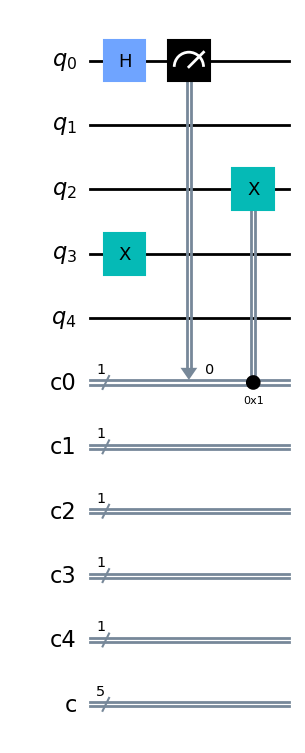

In [325]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit.from_qasm_file("./input_circuits_n_5_dp_10_dn_7_14_res_False/c_0.qasm")
circuit.draw(output='mpl')

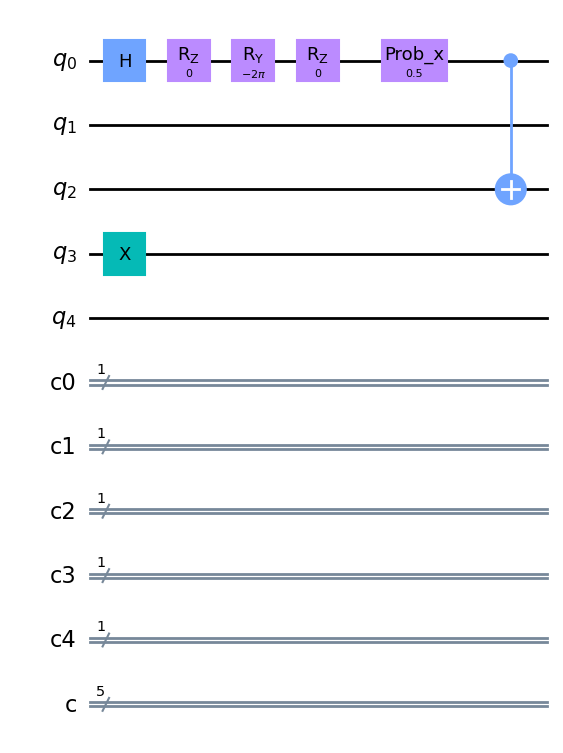

In [328]:
circuit = QuantumCircuit.from_qasm_file("./output_circuits_n_5_dp_10_dn_7_14_res_False/output_c_0.qasm")
circuit.draw(output='mpl')

/Users/innocenzo/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:4116: FutureWarning: Conditioned gates in qasm2 will be loaded as an IfElseOp starting in Qiskit 2.0
  return qasm2.loads(


      ┌───┐┌─┐ ┌───┐                
 q_0: ┤ H ├┤M├─┤ H ├────────────────
      └───┘└╥┘ ├───┤ ┌───┐┌─┐ ┌───┐ 
 q_1: ──────╫──┤ X ├─┤ H ├┤M├─┤ H ├─
            ║  └─╥─┘ └───┘└╥┘ ├───┤ 
 q_2: ──────╫────╫─────────╫──┤ X ├─
            ║ ┌──╨──┐      ║  └─╥─┘ 
c0: 1/══════╩═╡ 0x0 ╞══════╬════╬═══
            0 └─────┘      ║ ┌──╨──┐
c1: 1/═════════════════════╩═╡ 0x0 ╞
                           0 └─────┘
c2: 1/══════════════════════════════
                                    
 c: 3/══════════════════════════════
                                    


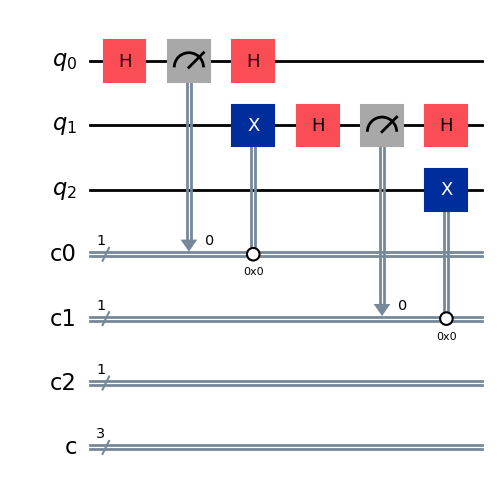

In [1]:
from qiskit import QuantumCircuit

qasm_string = """
OPENQASM 2.0;
include "qelib1.inc";

// Quantum registers
qreg q[3];

// Classical registers for classical controlled operations
creg c0[1]; // Register for qubit #0
creg c1[1]; // Register for qubit #1
creg c2[1]; // Register for qubit #2

// Classical registers for other operations
creg c[3];

h q[0];
measure q[0] -> c0[0];
if (c0 == 0) x q[1];
h q[0];

h q[1];
measure q[1] -> c1[0];
if (c1 == 0) x q[2];
h q[1];
"""

# Creare il circuito da stringa QASM
qc = QuantumCircuit.from_qasm_str(qasm_string)

# Mostrare il circuito
print(qc)  # ASCII output
qc.draw("mpl")  # Disegna il circuito graficamente